# Data Exploration

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['sessions.csv', 'test_users.csv', 'age_gender_bkts.csv', 'countries.csv', 'sample_submission.csv', 'sample_submission_NDF.csv', 'train_users_2.csv']


In [2]:
print(python.__version__)
print(pandas.__version__)
print(numpy.__version__)

NameError: name 'python' is not defined

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline
import pickle
from datetime import datetime, date

In [4]:
# load the datasets
training_data = pd.read_csv('../input/train_users_2.csv')
sessions = pd.read_csv('../input/sessions.csv')
countries = pd.read_csv('../input/countries.csv')
age_gender = pd.read_csv('../input/age_gender_bkts.csv')

## Variable Identification


In [5]:
# spliting predictor and target in the training data
training_predictor = training_data.drop('country_destination', axis=1)
target = training_data['country_destination']

display(training_predictor.head())

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome


 - **training_user.csv**
    - id: user id
    - date_account_created: the date of account creation
    - timestamp_first_active: timestamp of the first activity, note that it can be earlier than date_account_created or date_first_booking because a user can search before signing up
    - date_first_booking: date of first booking
    - gender
    - age
    - signup_method
    - signup_flow: the page a user came to signup up from
    - language: international language preference
    - affiliate_channel: what kind of paid marketing
    - affiliate_provider: where the marketing is e.g. google, craigslist, other
    - first_affiliate_tracked: whats the first marketing the user interacted with before the signing up
    - signup_app
    - first_device_type
    - first_browser
    - country_destination: this is the target variable you are to predict


### Data types of variables

In [6]:
display(training_predictor.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213451 entries, 0 to 213450
Data columns (total 15 columns):
id                         213451 non-null object
date_account_created       213451 non-null object
timestamp_first_active     213451 non-null int64
date_first_booking         88908 non-null object
gender                     213451 non-null object
age                        125461 non-null float64
signup_method              213451 non-null object
signup_flow                213451 non-null int64
language                   213451 non-null object
affiliate_channel          213451 non-null object
affiliate_provider         213451 non-null object
first_affiliate_tracked    207386 non-null object
signup_app                 213451 non-null object
first_device_type          213451 non-null object
first_browser              213451 non-null object
dtypes: float64(1), int64(2), object(12)
memory usage: 24.4+ MB


None

Out of 15 predictors we have 12 object type which says that they are mainly categorical or textual type of data. whereas two int and one float type present.

let's divide the preditors into two set, one with categorical and another with numerical.

In [7]:
predictors = list(training_predictor.columns)
numeric_predictors = []
categorical_predictors = []

for p in predictors:
    if training_predictor[p].dtype == np.object:
        categorical_predictors.append(p)
    else:
        numeric_predictors.append(p)
        
print("Categorical predictors list: {}".format(categorical_predictors))
print("\nNumerical predictorsl list: {}".format(numeric_predictors))

Categorical predictors list: ['id', 'date_account_created', 'date_first_booking', 'gender', 'signup_method', 'language', 'affiliate_channel', 'affiliate_provider', 'first_affiliate_tracked', 'signup_app', 'first_device_type', 'first_browser']

Numerical predictorsl list: ['timestamp_first_active', 'age', 'signup_flow']


## Missing Value Detection

In [8]:
def show_missing(X, columns):
    missing_count = X.isnull().sum()
    missing_percent = X.isnull().sum() * 100 / len(X)
    missing_value_df = pd.DataFrame({'column_name': columns, '#missing_values': missing_count,
                                     '% missing':missing_percent})
    return missing_value_df

missing_df = show_missing(training_predictor, predictors).sort_values('% missing', ascending=False)
missing_df

,column_name,#missing_values,% missing
date_first_booking,date_first_booking,124543,58.347349
age,age,87990,41.222576
first_affiliate_tracked,first_affiliate_tracked,6065,2.841402
id,id,0,0.000000
date_account_created,date_account_created,0,0.000000
timestamp_first_active,timestamp_first_active,0,0.000000
gender,gender,0,0.000000
signup_method,signup_method,0,0.000000
signup_flow,signup_flow,0,0.000000
language,language,0,0.000000


Text(0.5,1,'Column_name vs Missing %')

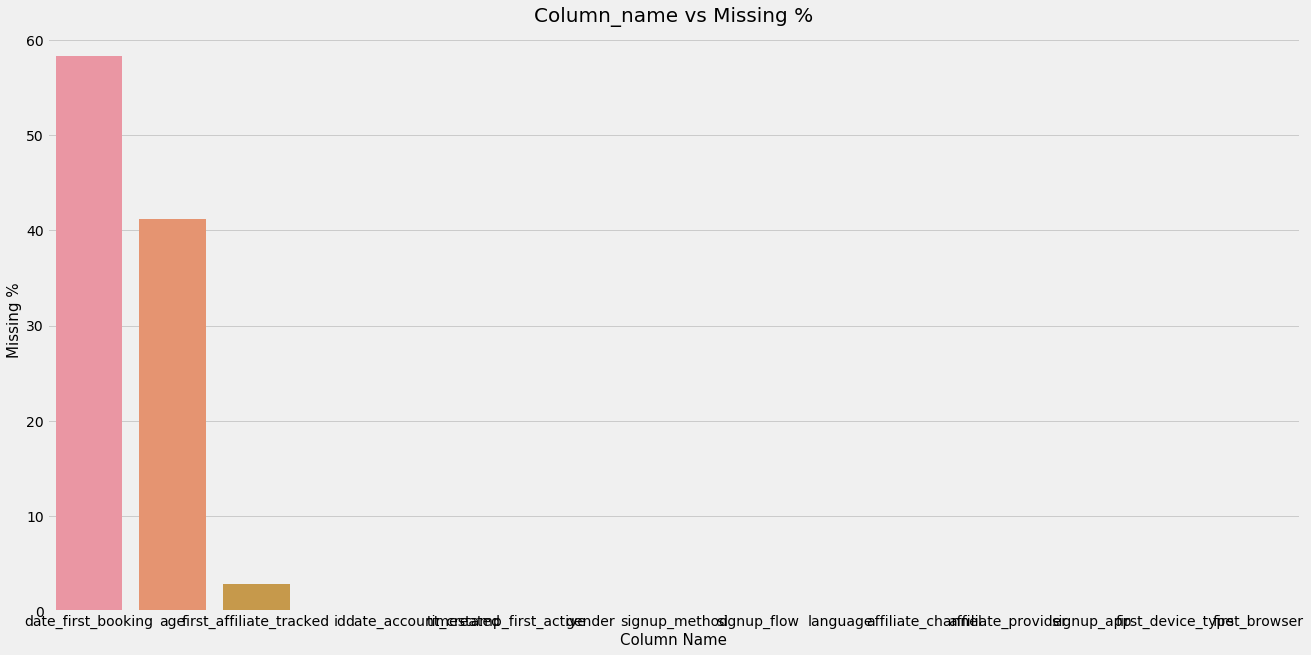

In [9]:
# plot the missing percentage
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(20, 10))
sns.barplot('column_name', '% missing', data=missing_df, ax=ax)
plt.xlabel('Column Name', size=15)
plt.ylabel('Missing %', size=15)
plt.title('Column_name vs Missing %', size=20)

> ** Insight **: In the collected dataset we don't have the first date of booking for more than half of the user. Moreover either many user didn't provide their age while signing up or somehow while parsing the data ages were missing as it is also nearer to half of the data.

For further analysis we will replace the missing ages with -1 and will drop the date_first_booking because it contains more than half missing values.

In [10]:
training_predictor = training_predictor.fillna(-1)
training_predictor = training_predictor.drop(['date_first_booking'], axis=1)
training_predictor.head()

,id,date_account_created,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser
0,gxn3p5htnn,2010-06-28,20090319043255,-unknown-,-1.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome
1,820tgsjxq7,2011-05-25,20090523174809,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome
2,4ft3gnwmtx,2010-09-28,20090609231247,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE
3,bjjt8pjhuk,2011-12-05,20091031060129,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox
4,87mebub9p4,2010-09-14,20091208061105,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome


## Univariate Analysis

### Gender
** Does women tend to book holidays more often than men?**


We need to analyse which type of gender are more interested in vacation so that in future deals we can make a better holiday packages. Let's study gender for the booking.
But wait, we can see there is one '-unknown- category of gender present in the dataset. Which means for that booking the gender is not known, before moving into anything let's see how this affects the booking.

Text(0.5,1,'Frequency of each gender')

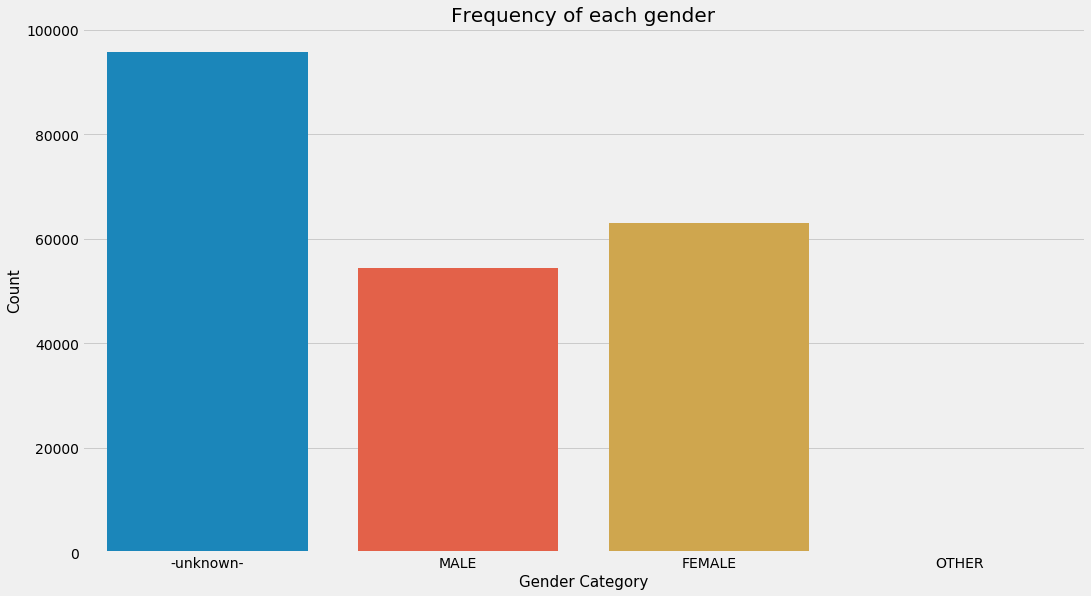

In [11]:
# studying gender category
fig, ax = plt.subplots(figsize=(16, 9))
sns.countplot(x='gender', data=training_predictor, ax=ax)
plt.xlabel('Gender Category', size=15)
plt.ylabel('Count', size=15)
plt.title('Frequency of each gender', size=20)

Well if we see the plot then we can conclude that apart from those -unknown- value "FEMALE" are more interested to book holidays than "MALE". Next time when travel company like Airbnb launch their holiday packages should give more priority to the "FEMALES".
But what about those "-unknown-" category, will this category affect the frequency of MALE/FEMALE. What if those -unknown- category have more "MALES" which can reject our hypothesis that more "FEMALES" booked tickets.

One solution come to mind is to impute these missing values either with a central tendency or using knn to predict the missing values. As this notebook is meant only for data analysis we will not impute now we will impute this in next notebook where we actually building the model.

### Age
** Who travels more young people or elder people after retirement?**


Let's check the distribution of age feature. We will see how the ages vary in the dataset. whether people with small age tends to book tickets more or people with more age book. From this one thing will be clear that how age matters in these holiday packages.

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'Distribution of age')

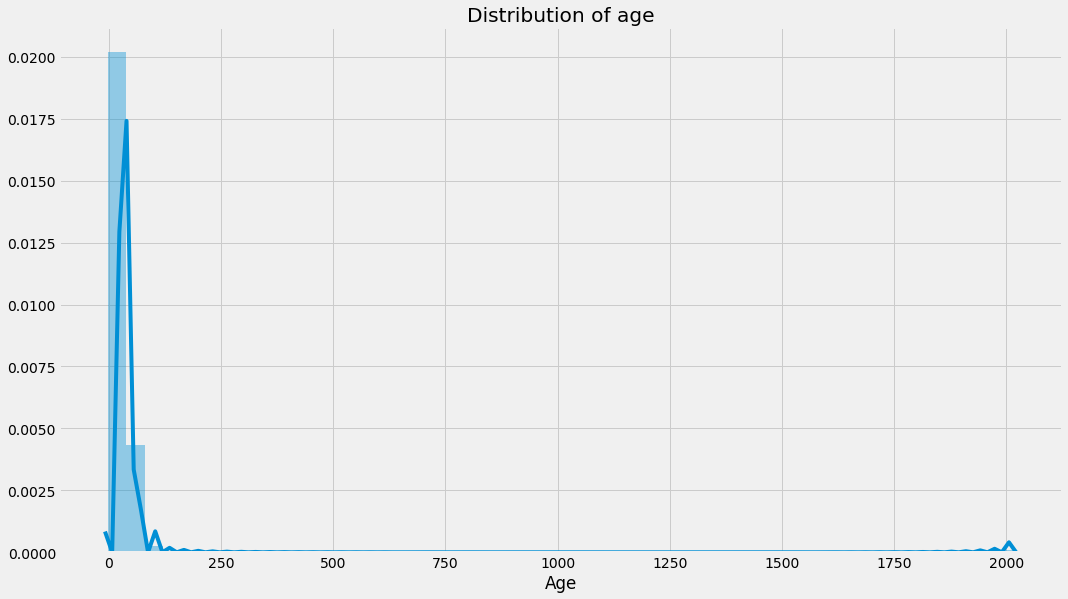

In [12]:
fig, ax=plt.subplots(figsize=(16, 9))
sns.distplot(training_predictor['age'].dropna(), ax=ax)
plt.xlabel('Age')
plt.title('Distribution of age')

That's errorneous as we can see it is skewed distribution which is tailed towards right and one important thing to notice is age with more than 100, 150 is also present. Moreover a large proporting of age data revolves around '0'. We can say that these ages are errorneous. For this we can use some data cleaning. 

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,0,'Age')

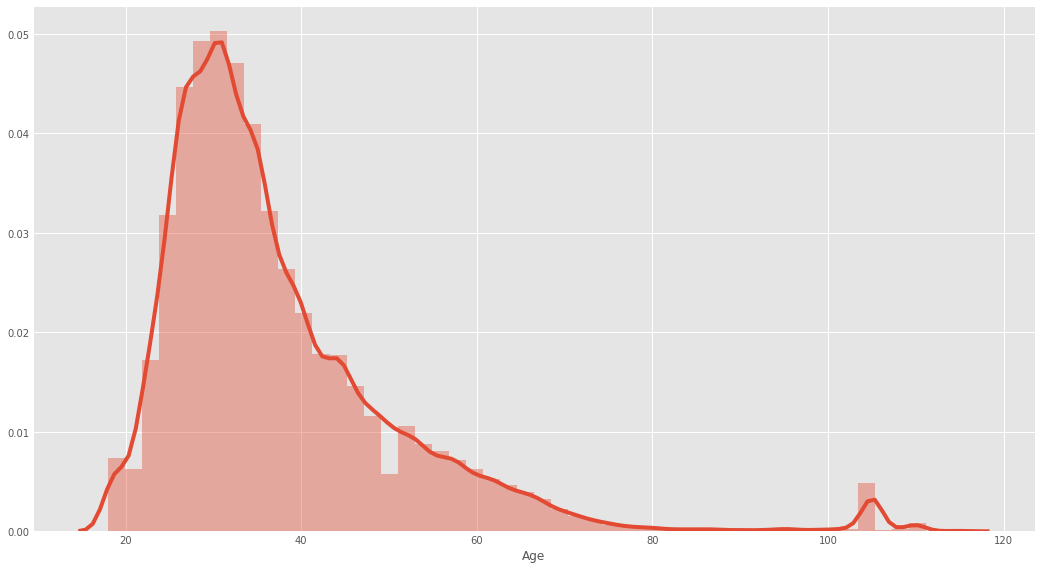

In [13]:
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(16, 9))
training_predictor.loc[training_predictor.age < 18] = np.nan
training_predictor.loc[training_predictor.age > 120] = np.nan

sns.distplot(training_predictor['age'].dropna())
plt.xlabel('Age')

That's gives us a bit clearer idea about the age distribution. So from the distribution we can say that young people are more attracted to visit new places than elder people. We can also see there is a linearly decline after age 40 and when it reaches around 65-70 there is zero chances of booking of holiday. 
Well that's obvious because when people are at their young age they love to travel and stay at new places. In this case our hypothesis holds. But one question must be asked here what about the ages less than 18, there is a probability that people at their young age like college students may book tickets to have party(considering the part that they are from wealthy family...just kidding...). Well that may be a case but most often Airbnb has some policy regarding this so if in the dataset it seems to have errorneous ages these might be due to wrong data points.

### Signup method
** Does people spends time to sign up or sign up through their favorite social site if yes then which social site have higher percentage of helping to signing up?**

This is a generous question as when people tends to regiter for a website they wants to do it as quickly as possible so they there is very good chance that people did sign up more with their social accoutn and I will not be surprised if people used mostly facebook/google for the same.
So let's find out what the data says about this !!!

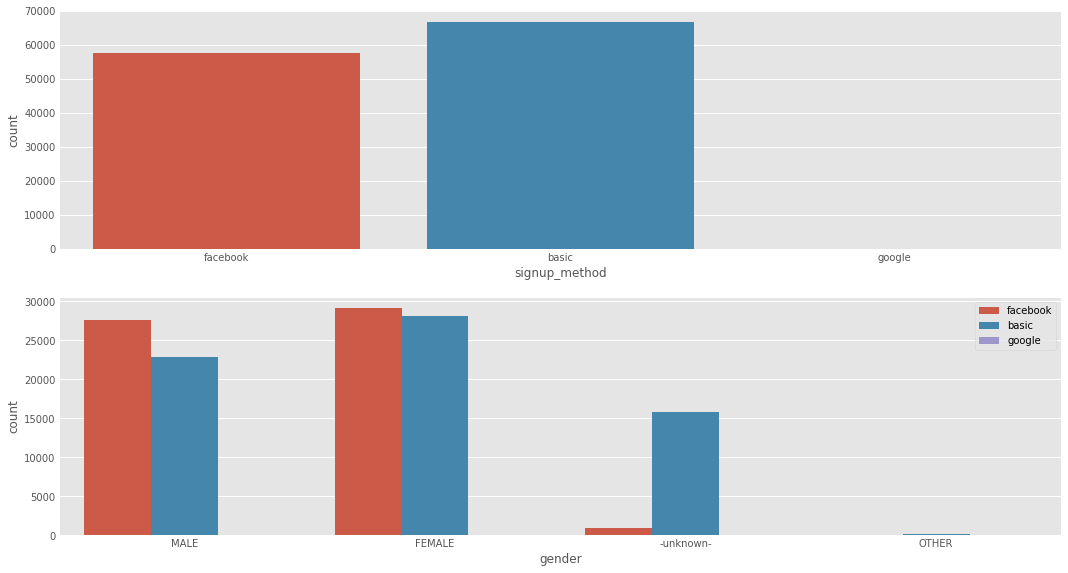

In [14]:
fig, ax = plt.subplots(figsize=(16,9), nrows=2, ncols=1)
sns.countplot(x='signup_method', data=training_predictor,ax=ax[0])

sns.countplot(x='gender', data=training_predictor, hue='signup_method',ax=ax[1])
plt.legend(loc='upper right')

That's really interesting many people have signed up using the basic method and almost zero from google. That's really interesting but what positive is from this is people have signed up using facebook in large number which also provides a great solution to increase number of customers.

> Airbnb can start to give ads on facebook with exciting offers on the post, which will lead people to sign up for Airbnb more and more. The logic behind is as we know people use facebook in large numbers and we also saw that people have signed up with facebook too which shows that our user base has also a larger number of facebook user. And when Airbnb provides a good offer through facebook ad service people tends to sign up and may be ended with a holiday plan.

Another outcome I found is, if we compare both male and female in the signing process then females has almost same frequency in both cases i.e facebook/basic method. But if we look at those male section then we can see that males has some more signing up with facebook than basic method. This also helps us to categorize how the gender group differs with signing up methods.

And this may come in handy when we will design model. 

### signup_app
** Airbnb users signed up more with web app or mobile app, which one has more popularity?**

A basic intution says that for the signup process people may have used web app more than mobile app. No doubt mobile apps are in trendy now and also very ease to access but what may be the reason for this is when people first signup for something they dont want any rush and discomfort. And webapps are preety convenient for signing up. But that's what I think, let's ask data what it has to show for us!!!

**Data never lies!!!...But with missing values do :D**

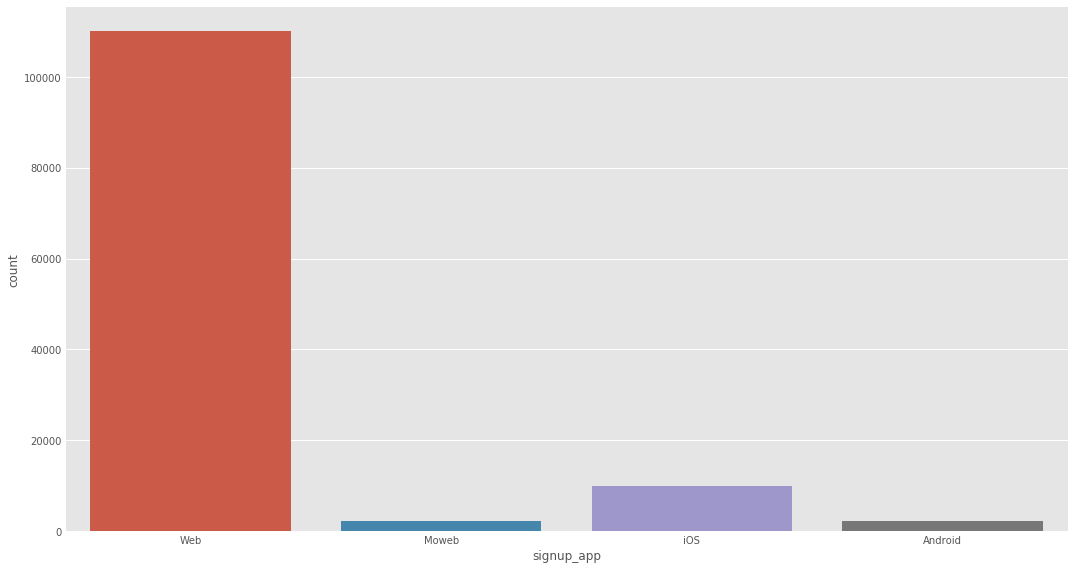

In [15]:
fig, ax = plt.subplots(figsize=(16, 9))
sns.countplot(x='signup_app', data=training_predictor)

That's as expected, Winner Winner Web is the beamer. Web is totally ruling this process and ahead of mobile apps. On the other side we can see that there are more iOS people than Android. This may be due to the dataset has more US citizens or Airbnb has a very good number of wealthy customers..Hmmmm...they have Iphone :3 :p

> But that doesn't tell us that which app is used for most bookings, this is just for the signing up process. So may be after signing up customers tend to use mobile apps more to do bookings and all. As of now we are just analysing one dataset, in future if we see more datasets then maybe we get some hint from those.

### first_browser
** Which browser helps Airbnb customers for signing up, is it Chrome/FIrefox or Internet Explorer? **

** Finding out top 10 browsers**


(0, 10)

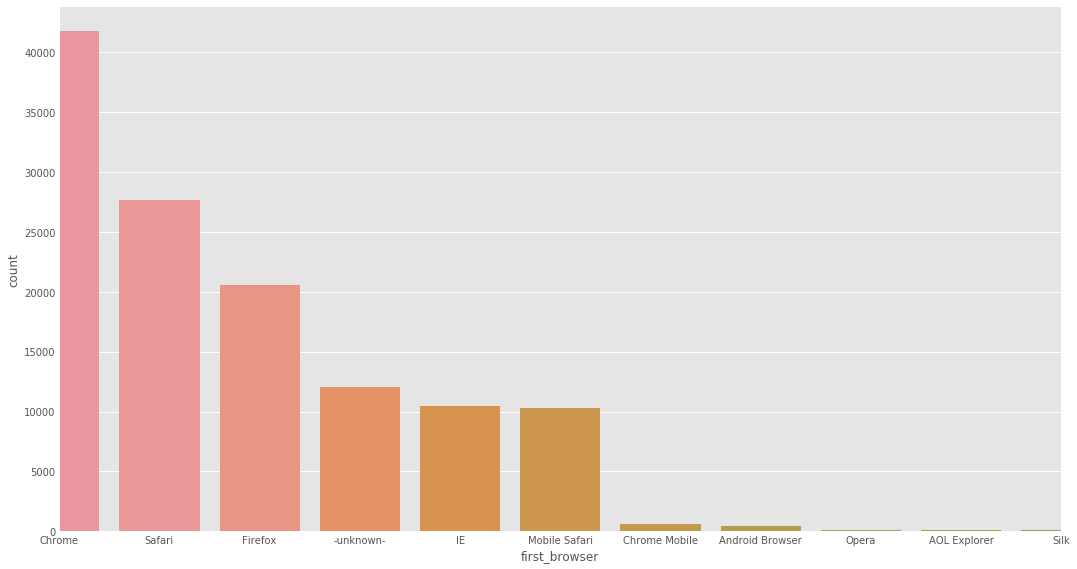

In [16]:

fig, ax = plt.subplots(figsize=(16, 9))
sns.countplot(x='first_browser', data=training_predictor, 
              order=training_predictor['first_browser'].value_counts(ascending=False).index)
plt.xlim(0, 10)

Chrome has the highest number of signing up people, then again Safari this shows how Apple users are fond of Airbnb. Interesting isn't it!!! Then Firefox and we can see after 5 we can see mobile browsers where Safari is leading. As we have already seen that there are more iPhones than Android so this might be due to that. 

**  In which years and months maximum number of accounts were created?**

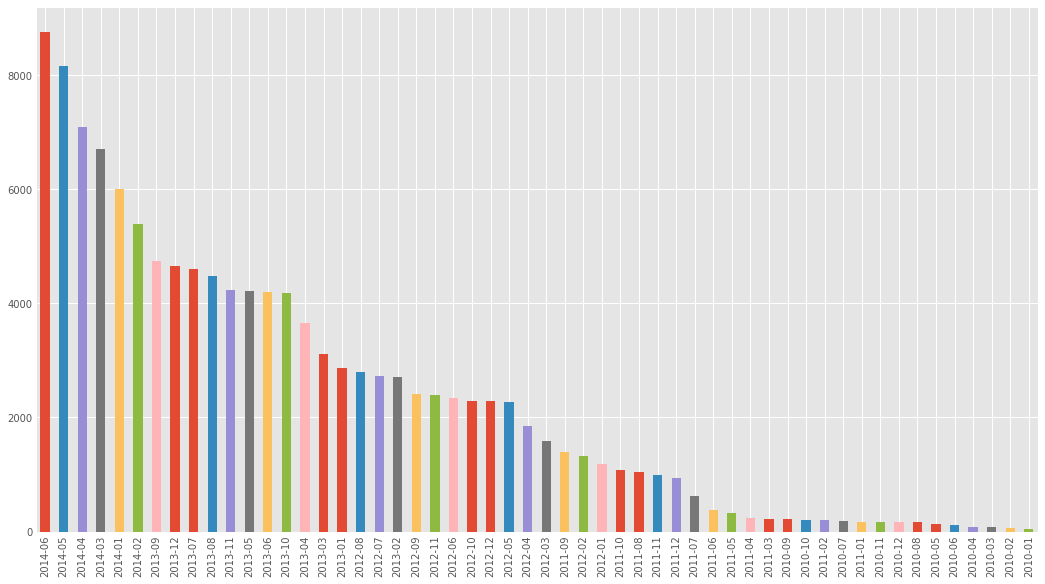

In [17]:
import pandas as pd
fig, ax = plt.subplots(figsize=(16, 9))
s = pd.to_datetime(training_predictor['date_account_created'])
s.index = s.dt.to_period('m')
s = s.groupby(level=0).size()

s = s.reindex(pd.period_range(s.index.min(), s.index.max(), freq='m'), fill_value=0).sort_values(ascending=False)
s.plot.bar(ax=ax)

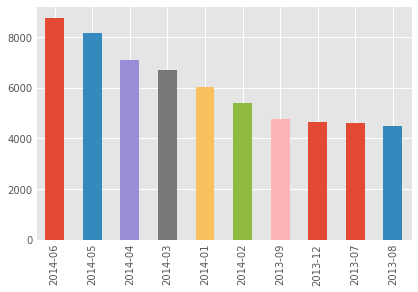

In [18]:
s.sort_values(ascending=False)[:10].plot.bar()

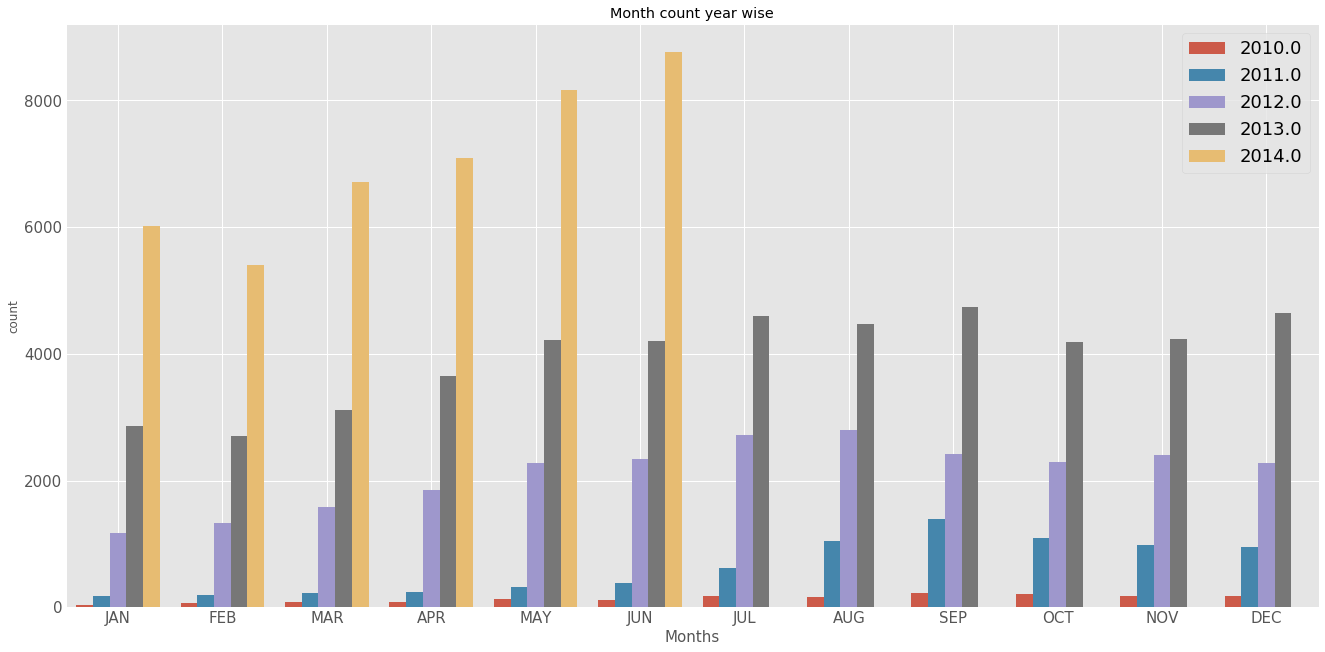

In [19]:
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(20, 10))
date_account = pd.DataFrame(pd.to_datetime(training_predictor["date_account_created"]))
date_account["year"]=date_account["date_account_created"].dt.year
date_account["month"]=date_account["date_account_created"].dt.month
sns.countplot(x='month', data=date_account, hue="year", ax=ax)
ax.set_title("Month count year wise")
ax.set_xlabel("Months", size=15)
ax.set_xticklabels(["JAN", "FEB", "MAR", "APR", "MAY", "JUN", "JUL", "AUG", "SEP", 
                    "OCT", "NOV", "DEC"])
ax.tick_params(labelsize=15)
ax.legend(loc='upper right', prop={'size':18})
ax.grid(True)

Huhh!!! That's a bit graphical. Let's break down one by one.

** Plot 1 ** This plot shows that account creation on each year and respective months. And we can see that from starting year it is preety low and gradually it increases, but this plot is bit clumsy.

** Plot 2 ** This one is just an extend to the first one which shows that top 10 year-month where most accounts were created and we can see in 2014, march, april, may and june had most number of accounts were created.
This is because by 2014 this platform is quite popular among the people.

** Plot 3 ** This plot describes the most informative one as it shows the monthly created users by years and  we can see that again in 2014 only jun has the highest number of accounts created. and after that we dont have data. so this is preety conclusive that Airbnb has managed to increase its customer base day by day.

| Year   |      Most_user_month |
|----------|:-------------:|
| 2014 | June |
| 2013 | September |
| 2012 | August |
| 2011 | September |
| 2010 | September |

> September is the one who has brought more number of users in 3 years so September can be a month of providing most number of offers.

With this we will stop with univariate analysis. Now we will see how one variable affects the other and how they realted to each other. 

## Bivariate Analysis

In this section we will try to find out interesting relations between predictors and with the target variable also. This will helps us to understand the importance of variables and by using that knowledge we can build our intutions. 

In our dataset we have several numerical and while others are categorical variables. So we will go one by one and will try to discover hiddent informations from the data.

